In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
options = Options()
options.binary_location = 'geckodriver'


In [3]:
import time
from urllib.request import Request, urlopen
from urllib.error import HTTPError

# Define la URL base
base_url = "https://www.infocasas.com.uy/alquiler/inmuebles/pagina"

# Número total de páginas
total_pages = 50

# Lista para almacenar el HTML de cada página
html_base = []

# Set the number of retries
max_retries = 3

# Set the initial delay between retries
retry_delay = 1

# Itera sobre todas las páginas
for page_number in range(1, total_pages + 1):
    # Construye la URL completa para la página actual
    url = f"{base_url}{page_number}"

    # This packages the request
    request = Request(url)

    # Retry the request for a maximum number of times
    for retry in range(max_retries):
        try:
            # Sends the request and catches the response: response
            response = urlopen(request)

            # Extract the response: html
            html = response.read()

            # Agrega el HTML al array html_data
            html_base.append(html)

            # Be polite and close the response!
            response.close()

            # Break out of the loop if the request is successful
            break

        except HTTPError as e:
            # Print the error message
            print(f"HTTP Error: {e.code} - {e.reason}")

            # Retry after a delay
            time.sleep(retry_delay)

            # Increase the delay for the next retry
            retry_delay *= 2

    else:
        # If all retries fail, print an error message
        print(f"Maximum number of retries reached for page {page_number}. Request failed.")



In [4]:
from bs4 import BeautifulSoup

# Create an empty array to store the processed HTML elements
sopita = []

# Loop through each html_code element
for html in html_base:
    soup = BeautifulSoup(html, 'lxml')

    sopita.append(soup)

In [5]:
    links_array = []

    for soup in sopita:
        links = soup.find_all('a', class_='lc-cardCover')
        links_array.extend(links)

In [6]:
urls = [link['href'] for link in links_array]
urls = [f"https://www.infocasas.com.uy{link}" for link in urls]

In [7]:
len(urls)

1050

In [8]:
# Lista para almacenar el HTML de cada página
html_data = []

# Set the number of retries
max_retries = 3

# Set the initial delay between retries
retry_delay = 1

# Asume que `urls` es el arreglo que contiene las URLs completas para hacer las solicitudes
# urls = [...]

# Itera sobre todas las URLs en el arreglo
for index, url in enumerate(urls, start=1):
    # This packages the request
    request = Request(url)

    # Retry the request for a maximum number of times
    for retry in range(max_retries):
        try:
            # Sends the request and catches the response: response
            response = urlopen(request)

            # Extract the response: html
            html = response.read()

            # Agrega el HTML al array html_data
            html_data.append(html)

            # Be polite and close the response!
            response.close()

            # Break out of the loop if the request is successful
            break

        except HTTPError as e:
            # Print the error message
            print(f"HTTP Error: {e.code} - {e.reason} on page {index}")

            # Retry after a delay
            time.sleep(retry_delay)

            # Increase the delay for the next retry
            retry_delay *= 2

    else:
        # If all retries fail, print an error message
        print(f"Maximum number of retries reached for page {index}. Request failed.")


HTTP Error: 504 - Gateway Time-out on page 10
HTTP Error: 504 - Gateway Time-out on page 323
HTTP Error: 404 - Not Found on page 571
HTTP Error: 404 - Not Found on page 571
HTTP Error: 404 - Not Found on page 571
Maximum number of retries reached for page 571. Request failed.
HTTP Error: 404 - Not Found on page 902
HTTP Error: 404 - Not Found on page 902
HTTP Error: 404 - Not Found on page 902
Maximum number of retries reached for page 902. Request failed.


In [9]:
len(html_data)

1048

In [10]:
prices = []
for html in html_data:
    price_element = BeautifulSoup(html, 'lxml').find('span', class_='ant-typography price')
    if price_element:
        price = price_element.text
        prices.append(price)
    else:
        prices.append('N/A')  # Add a placeholder value if the element is not found


In [11]:
gastos_list = []

for html in html_data:
    gastos_tags = BeautifulSoup(html, 'lxml').find_all('span', class_='ant-typography ant-typography-secondary commonExpenses')
    if gastos_tags:  # Verificar si hay elementos encontrados
        gastos_text = ''.join(tag.text for tag in gastos_tags)  # Unir el texto de todos los elementos encontrados
        gastos_list.append(gastos_text)
    else:
        gastos_list.append('0')  # Agregar '0' si no se encontraron elementos

In [12]:
import json
from bs4 import BeautifulSoup

# Initialize an empty list to hold all technical sheets from all HTML contents
casas = []

# Loop through each HTML content in 'html_data'
for html_content in html_data:
    soup = BeautifulSoup(html_content, 'html.parser')
    script_tag = soup.find('script', {'id': '__NEXT_DATA__'})
    json_text = script_tag.string if script_tag else '{}'
    data = json.loads(json_text)
    
    # This checks if 'property_keys' can be found in the data
    if 'props' in data and 'pageProps' in data['props'] and 'apolloState' in data['props']['pageProps']:
        property_keys = [key for key in data['props']['pageProps']['apolloState'].keys() if key.startswith('Property:')]
        
        if property_keys:
            # Assuming there is at least one property key
            technical_sheet = data['props']['pageProps']['apolloState'][property_keys[0]].get('technicalSheet', [])
            
            # Process the technical sheet to your desired format here
            # For example, convert each item to a tuple of (text, value)
            formatted_technical_sheet_tuples = [(item['text'], item['value']) for item in technical_sheet]
            
            # Append the processed technical sheet for this HTML content to the all_technical_sheets list
            casas.append(formatted_technical_sheet_tuples)

In [13]:
for i in range(len(casas)):
    casas[i].append(('Precio', prices[i]))


In [169]:
import pandas as pd

# Suponiendo que casas es una lista de listas, donde cada sublista contiene tuplas (nombre, valor) que representan las características de una casa

# Crear un conjunto para almacenar todos los nombres de características encontrados en todas las casas
todos_los_nombres = set()
for casa in casas:
    for nombre, _ in casa:
        todos_los_nombres.add(nombre)

# Crear un diccionario para almacenar los valores de las características para cada casa
datos_dict = {}
for i, casa in enumerate(casas):
    casa_dict = dict(casa)
    datos_dict[i] = casa_dict

# Crear el DataFrame
df = pd.DataFrame.from_dict(datos_dict, orient='index')

# Ordenar las columnas por los nombres de características
df = df.reindex(sorted(todos_los_nombres), axis=1)

# Imprimir el DataFrame


In [170]:
df.drop('Contrato Mínimo', axis=1, inplace=True)
df.drop('Acepta mascotas', axis=1, inplace=True)



In [171]:
import numpy as np
df.head(3)


,Apartamentos por Pisos,Año de Construcción,Barrio Privado,Baños,Cantidad de Pisos,Disposición,Dormitorios,Estado,Garajes,Gastos Comunes,...,M² del terreno,M² edificados,Piso,Plantas,Precio,Referencia,Sobre,Tipo de Propiedad,Vivienda Social,Zona
0,NaN,,,4,NaN,No aplica,3,Buen estado,,NaN,...,1.000 m2,,NaN,,"U$S 4,200",Z6132A,No aplica,Casa,,La Barra
1,NaN,,,8,NaN,No aplica,6,Buen estado,,NaN,...,1.100 m2,300 m2,NaN,,"U$S 5,500",V8F603,No aplica,Casa,,La Barra
2,,,,1,10,No aplica,,Sin Definir,1,$ 17.000,...,,110 m2,,1,"$ 49,000",H38772,No aplica,Apartamento,,Malvín


In [172]:
df['M² de terraza'] = df['M² de terraza'].str.extract('(\d+)').astype(float)
df['M² edificados'] = df['M² edificados'].str.extract('(\d+)').astype(float)
df['M² del terreno'] = df['M² del terreno'].str.extract('(\d+)').astype(float)


In [173]:
df['Precio'] = df['Precio'].str.replace('.', '')
df['Precio'] = df['Precio'].str.replace(',', '')

df[['Moneda', 'Monto']] = df['Precio'].str.split(' ', n=1, expand=True)
df['Monto'] = df['Monto'].astype(float)
df.drop('Precio', axis=1, inplace=True)


In [174]:
df.loc[df['Moneda'] == 'U$S', 'Monto'] *= 40


In [175]:
import pandas as pd

# Supongamos que df es tu DataFrame y 'Monto' es la columna de interés

# Calculamos el primer y tercer cuartil
Q1 = df['Monto'].quantile(0.25)
Q3 = df['Monto'].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites para considerar un dato como outlier
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificamos los outliers
outliers = df[(df['Monto'] < limite_inferior) | (df['Monto'] > limite_superior)]

# Eliminamos los outliers del DataFrame original
df = df[(df['Monto'] >= limite_inferior) & (df['Monto'] <= limite_superior)]


<Axes: xlabel='Moneda', ylabel='Monto'>

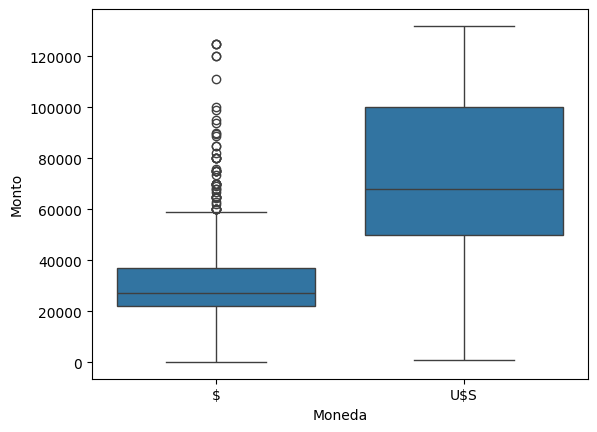

In [176]:
import seaborn as sns

sns.boxplot(x='Moneda', y='Monto', data=df)

<Axes: xlabel='Monto', ylabel='Count'>

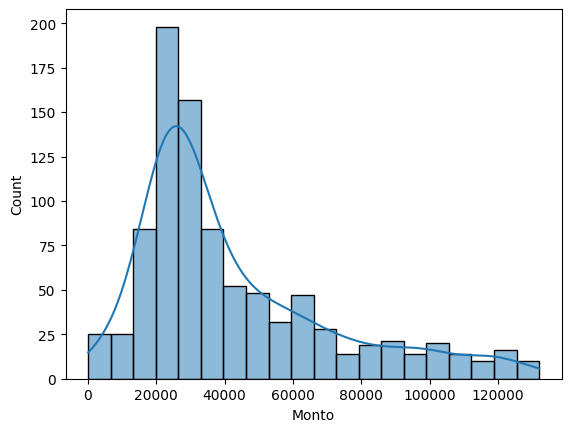

In [148]:
sns.histplot(df['Monto'], kde=True)

In [177]:
df['Año de Construcción'] = df['Año de Construcción'].replace('¡Preguntale!	', np.nan)
df['Año de Construcción'] = pd.to_numeric(df['Año de Construcción'], errors='coerce')


In [178]:
df['Baños'] = pd.to_numeric(df['Baños'], errors='coerce')
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce')


In [179]:
df['Garajes'] = df['Garajes'].replace('¡Preguntale!', np.nan)
df['Garajes'] = pd.to_numeric(df['Garajes'], errors='coerce')

In [180]:
df['Plantas'] = df['Plantas'].replace('¡Preguntale!', np.nan)
df['Plantas'] = pd.to_numeric(df['Plantas'], errors='coerce')

In [181]:
df = df.drop('Referencia', axis=1)


In [182]:
df['Apartamentos por Pisos'] = df['Apartamentos por Pisos'].replace('¡Preguntale!', np.nan)
df['Apartamentos por Pisos'] = pd.to_numeric(df['Apartamentos por Pisos'], errors='coerce')


In [183]:
df['Piso'] = df['Piso'].replace('¡Preguntale!', np.nan)
df['Piso'] = pd.to_numeric(df['Piso'], errors='coerce')

In [184]:
df['Gastos Comunes'] = df['Gastos Comunes'].replace('¡Preguntale!', np.nan)
df['Gastos Comunes'] = pd.to_numeric(df['Gastos Comunes'], errors='coerce')

In [185]:
df['Sobre'] = df['Sobre'].replace('¡Preguntale!', np.nan)
df['Disposición'] = df['Disposición'].replace('¡Preguntale!', np.nan)
df['Zona'] = df['Zona'].replace('¡Preguntale!', np.nan)
df['Barrio Privado'] = df['Barrio Privado'].replace('¡Preguntale!', np.nan)
df['Estado'] = df['Estado'].replace('¡Preguntale!', np.nan)
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].replace('¡Preguntale!', np.nan)
df['Moneda'] = df['Moneda'].replace('¡Preguntale!', np.nan)
df['Vivienda Social'] = df['Vivienda Social'].replace('¡Preguntale!', np.nan)




In [187]:
df['Sobre'] = df['Sobre'].astype('category')
df['Disposición'] = df['Disposición'].astype('category')
df['Zona'] = df['Zona'].astype('category')
df['Barrio Privado'] = df['Barrio Privado'].astype('category')
df['Estado'] = df['Estado'].astype('category')
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].astype('category')
df['Moneda'] = df['Moneda'].astype('category')
df['Vivienda Social'] = df['Vivienda Social'].astype('category')

<Axes: xlabel='Moneda', ylabel='Monto'>

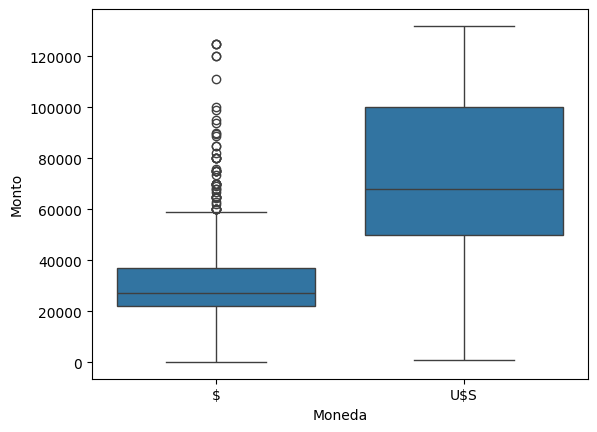

In [81]:
sns.boxplot(x='Moneda', y='Monto', data=df)

In [374]:
df_dummies = pd.get_dummies(df)


In [375]:
df_dummies.isnull().sum()

Apartamentos por Pisos                  0
Año de Construcción                     0
Barrio Privado                          0
Baños                                   0
Disposición                             0
Dormitorios                             0
Estado                                  0
Garajes                                 0
Hectáreas                               0
M² de terraza                           0
M² del terreno                          0
M² edificados                           0
Piso                                    0
Plantas                                 0
Sobre                                   0
Tipo de Propiedad                       0
Vivienda Social                         0
Moneda                                  0
Monto                                   0
Cantidad de Pisos_2352.8319542819477    0
Cantidad de Pisos_                      0
Cantidad de Pisos_1                     0
Cantidad de Pisos_10                    0
Cantidad de Pisos_11              

In [88]:
df['Gastos Comunes'].value_counts()

Series([], Name: count, dtype: int64)

In [361]:
df['Disposición'] = df['Disposición'].astype('category').cat.codes
df['Barrio Privado'] = df['Barrio Privado'].astype('category').cat.codes
df['Estado'] = df['Estado'].astype('category').cat.codes
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].astype('category').cat.codes
df['Moneda'] = df['Moneda'].astype('category').cat.codes
df['Vivienda Social'] = df['Vivienda Social'].astype('category').cat.codes

# Calculate the mean of the numeric columns in the DataFrame
mean_of_df = df.select_dtypes(include=[np.number]).mean().mean()

# Replace NaN values with the mean
df.fillna(mean_of_df, inplace=True)


In [373]:
df.isnull().sum()

Apartamentos por Pisos    0
Año de Construcción       0
Barrio Privado            0
Baños                     0
Cantidad de Pisos         0
Disposición               0
Dormitorios               0
Estado                    0
Garajes                   0
Hectáreas                 0
M² de terraza             0
M² del terreno            0
M² edificados             0
Piso                      0
Plantas                   0
Sobre                     0
Tipo de Propiedad         0
Vivienda Social           0
Moneda                    0
Monto                     0
dtype: int64

In [376]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_dummies.drop('Monto', axis=1)
y = df_dummies['Monto']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


array([[<Axes: title={'center': 'Monto'}>]], dtype=object)

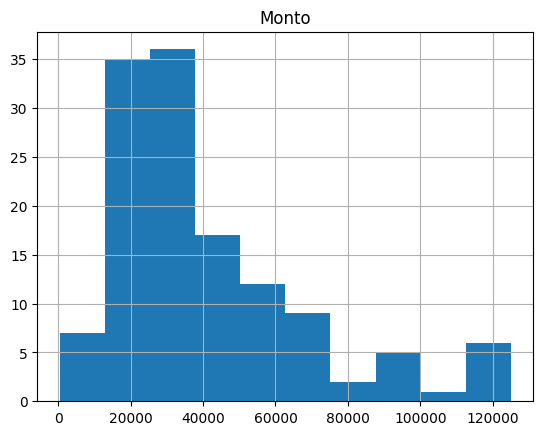

In [377]:
import pandas as pd
# Convert 'y_test' to a pandas DataFrame
y_test_df = pd.DataFrame(y_test)

# Plot the histogram
y_test_df.hist()


In [378]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Generar un conjunto de datos de regresión sintético

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [379]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_and_train_nn(X_train, y_train):
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, verbose=0)
    
    return model

nn_model = build_and_train_nn(X_train_scaled, y_train)


In [380]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)


GradientBoostingRegressor(random_state=42)

In [381]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [382]:
def ensemble_predictions(nn_model, gb_model, rf_model, X_test):
    # Predicciones de la red neuronal
    nn_pred = nn_model.predict(X_test).flatten()
    
    # Predicciones del Gradient Boosting
    gb_pred = gb_model.predict(X_test)
    
    # Predicciones del Bosque Aleatorio
    rf_pred = rf_model.predict(X_test)
    
    # Promedio de las predicciones
    final_pred = (nn_pred + gb_pred + rf_pred) / 3
    
    return final_pred

# Obtener y evaluar las predicciones ensambladas
final_predictions = ensemble_predictions(nn_model, gb_model, rf_model, X_test_scaled)
r2 = r2_score(y_test, final_predictions)
print(f"R^2 del ensamblado: {r2:.5f}")


5/5 [==============================] - 0s 1ms/step
R^2 del ensamblado: 0.26980


In [383]:
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
rmse

23395.49120867118

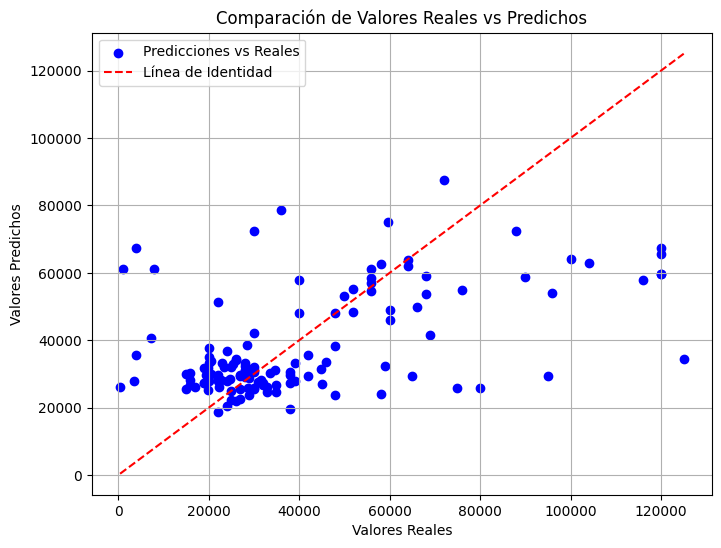

In [385]:
import matplotlib.pyplot as plt

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, color='blue', label='Predicciones vs Reales')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Línea de Identidad')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación de Valores Reales vs Predichos')
plt.legend()
plt.grid(True)
plt.show()
